This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

In [5]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [6]:
sequences_with_species_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [7]:
sequences_with_species_df.isnull().sum()

sequence      0
charge        0
file_idx      0
intensity     0
classed_as    0
run_name      0
batch         0
human         0
dtype: int64

In [8]:
TARGET_DECOY_MODEL_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models'
EXPERIMENT_METRICS_FILE_NAME = "{}/experiment-metrics-for-library-sequences.pkl".format(TARGET_DECOY_MODEL_DIR)

In [9]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [10]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [11]:
experiment_metrics_for_library_sequences_df.isnull().sum()

sequence                           0
charge                             0
theoretical_mz                     0
experiment_scan_mean               0
experiment_scan_std_dev            0
experiment_scan_peak_width         0
experiment_rt_mean                 0
experiment_rt_std_dev              0
experiment_rt_peak_width           0
experiment_intensity_mean          0
experiment_intensity_std_dev       0
number_of_runs_identified          0
q_value                            0
file_idx                           0
target_coords                      0
decoy_coords                       0
target_metrics                  1157
attributes                         0
decoy_metrics                   6537
dtype: int64

#### Merge the unpacked attributes of the TFD-extracted sequence (in experiment_metrics_for_library_sequences_df) with the sequences_with_species_df

In [12]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric values
    d = row.attributes
    if (d is not None) and all(d.values()):
        l = []
        l.append(row.sequence)
        l.append(row.charge)
        l.append(row.file_idx)
        l += [d[key] for key in sorted(d)]
        attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [13]:
attributes_as_extracted_df.isnull().sum()

sequence                0
charge                  0
file_idx                0
intensity_all_points    0
intensity_top_3         0
monoisotopic_mz         0
rt_apex                 0
scan_apex               0
dtype: int64

In [14]:
len(attributes_as_extracted_df)

586547

In [15]:
attributes_as_extracted_df.intensity_top_3.max(), attributes_as_extracted_df.intensity_top_3.min()

(51913, 9)

In [16]:
attributes_as_extracted_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex
0,AAAAAAAAAAAAAAAASAGGK,2,0,1956,331,778.415635,937.100303,533.000000
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,0,321139,6502,1184.609205,594.503517,70.440081
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,0,3014,328,1016.532371,486.625154,152.472187
3,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,0,8014,336,864.452576,1034.987311,708.747001
4,AAAAAWEEPSSGNGTAR,2,0,76396,1762,823.382040,367.242494,538.177052


In [17]:
len(sequences_with_species_df)

544165

In [18]:
len(attributes_as_extracted_df)

586547

In [19]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity)

In [20]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity'],
      dtype='object')

In [21]:
sequences_with_attributes_df.isnull().sum()

sequence                0
charge                  0
file_idx                0
intensity_all_points    0
intensity_top_3         0
monoisotopic_mz         0
rt_apex                 0
scan_apex               0
intensity               0
classed_as              0
run_name                0
batch                   0
human                   0
log_intensity           0
dtype: int64

In [22]:
len(sequences_with_attributes_df)

542616

In [23]:
# find the experiment-wide intensity median
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    median_intensity_in_experiment = group_df.log_intensity.median()
    mean_intensity_in_experiment = group_df.log_intensity.mean()
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,median_intensity_in_experiment,mean_intensity_in_experiment,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','median_intensity_in_experiment','mean_intensity_in_experiment','number_of_runs_identified'])

In [24]:
experiment_intensities_df.head()

,sequence,charge,median_intensity_in_experiment,mean_intensity_in_experiment,number_of_runs_identified
0,AAAAAAAAAAAAAAAASAGGK,2,8.408885,8.382765,20
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,12.028991,11.713211,20
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,8.629357,8.467888,7
3,AAAAAAAAVPSAGPAGPAPTSAAGR,2,8.693218,8.661215,20
4,AAAAALSQQQSLQER,2,9.372865,9.042123,15


In [25]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [26]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified'],
      dtype='object')

#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [27]:
sequences_df['delta_intensity_median'] = sequences_df.log_intensity - sequences_df.median_intensity_in_experiment
sequences_df['delta_intensity_mean'] = sequences_df.log_intensity - sequences_df.mean_intensity_in_experiment

In [28]:
# make the training set from human only, comprising sequences we have identified in a majority of runs
training_set_df = sequences_df[(sequences_df.human == True) & (sequences_df.number_of_runs_identified > 10)].copy()

In [29]:
training_set_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,classed_as,run_name,batch,human,log_intensity,median_intensity_in_experiment,mean_intensity_in_experiment,number_of_runs_identified,delta_intensity_median,delta_intensity_mean
0,AAAAAAAAAAAAAAAASAGGK,2,0,1956,331,778.415635,937.100303,533.000000,331,target,190719_Hela_Ecoli_1to3_06,1to3,True,8.370687,8.408885,8.382765,20,-0.038198,-0.012078
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,0,321139,6502,1184.609205,594.503517,70.440081,6502,target,190719_Hela_Ecoli_1to3_06,1to3,True,12.666668,12.028991,11.713211,20,0.637677,0.953457
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,0,3014,328,1016.532371,486.625154,152.472187,328,target,190719_Hela_Ecoli_1to3_06,1to3,True,8.357552,8.693218,8.661215,20,-0.335666,-0.303663
3,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,0,8014,336,864.452576,1034.987311,708.747001,336,target,190719_Hela_Ecoli_1to3_06,1to3,True,8.392317,8.661712,8.599057,20,-0.269395,-0.206740
4,AAAAAWEEPSSGNGTAR,2,0,76396,1762,823.382040,367.242494,538.177052,1762,target,190719_Hela_Ecoli_1to3_06,1to3,True,10.782998,11.516624,11.484457,20,-0.733625,-0.701459


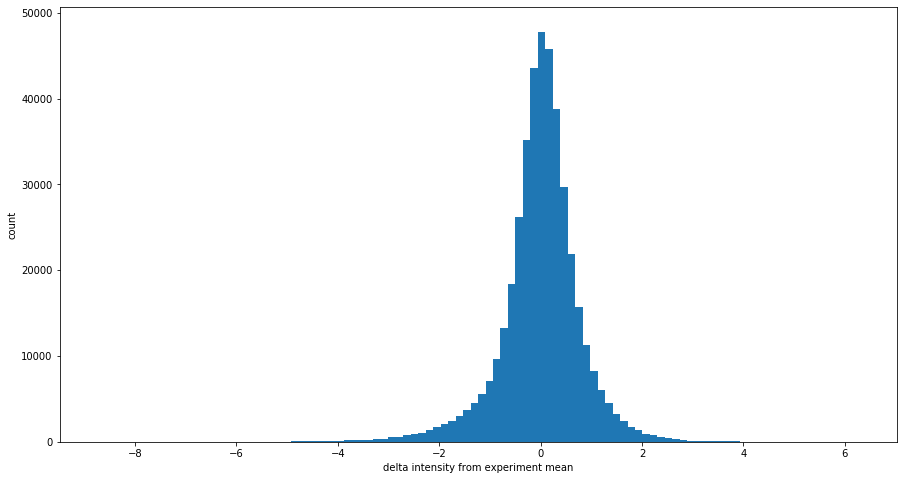

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_df.delta_intensity_mean, bins=bins)
plt.xlabel('delta intensity from experiment mean')
plt.ylabel('count')

plt.show()

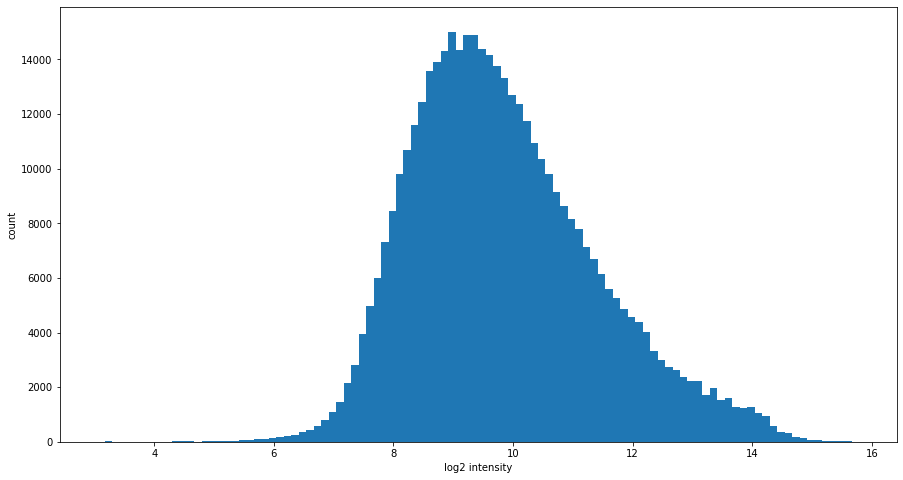

In [31]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_df.log_intensity, bins=bins)
plt.xlabel('log2 intensity')
plt.ylabel('count')

plt.show()

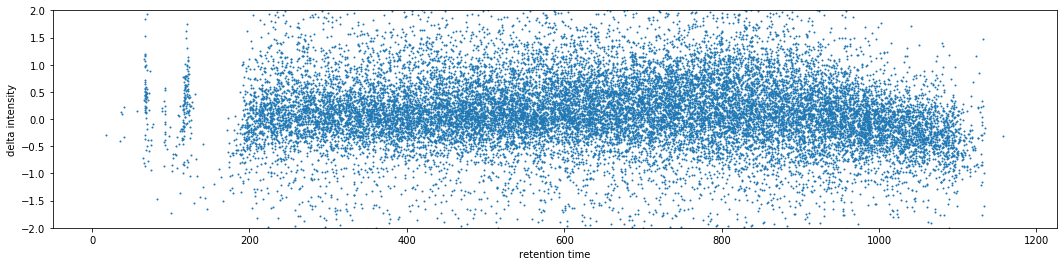

In [32]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

df = training_set_df[training_set_df.file_idx == 2]
ax.scatter(df.rt_apex, df.delta_intensity_mean, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-2,2))

plt.show()

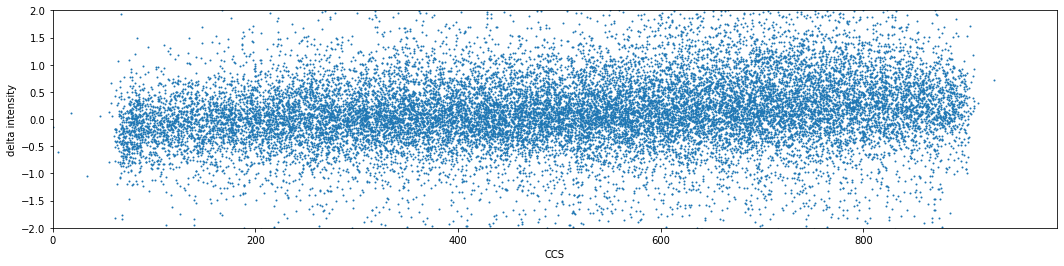

In [33]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(df.scan_apex, df.delta_intensity_mean, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('CCS')
plt.xlim((0,991))
plt.ylim((-2,2))

plt.show()

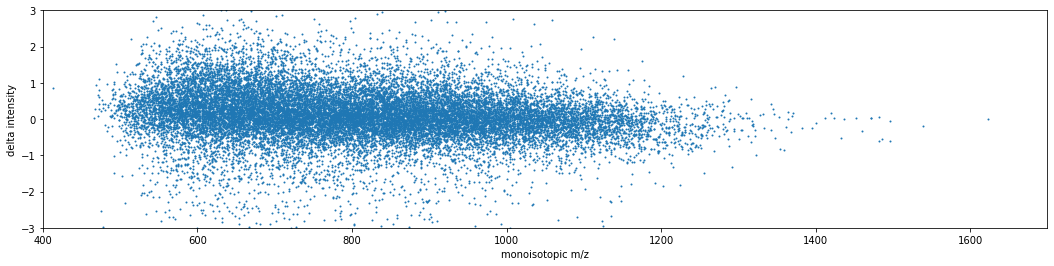

In [34]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(df.monoisotopic_mz, df.delta_intensity_mean, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('monoisotopic m/z')
plt.xlim((400,1700))
plt.ylim((-3,3))

plt.show()

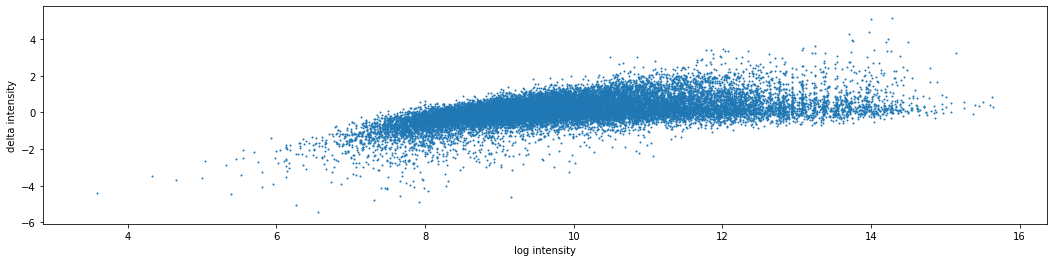

In [35]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(df.log_intensity, df.delta_intensity_mean, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('log intensity')
# plt.xlim((400,1700))

plt.show()

In [36]:
len(training_set_df)

425957

In [37]:
training_set_df.isnull().sum()

sequence                          0
charge                            0
file_idx                          0
intensity_all_points              0
intensity_top_3                   0
monoisotopic_mz                   0
rt_apex                           0
scan_apex                         0
intensity                         0
classed_as                        0
run_name                          0
batch                             0
human                             0
log_intensity                     0
median_intensity_in_experiment    0
mean_intensity_in_experiment      0
number_of_runs_identified         0
delta_intensity_median            0
delta_intensity_mean              0
dtype: int64

#### create a gradient boosted regressor model

In [38]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_distributions=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


#### train a model for a selected run

In [39]:
file_idx_for_this_model = 2

In [40]:
# filter out rows we don't want in the training set for this run-specific model
training_set_for_run_df = training_set_df[(training_set_df.file_idx == file_idx_for_this_model)]
print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

there are 21115 sequences in the training set for file 2


In [41]:
training_set_for_run_df[['sequence','charge','log_intensity','delta_intensity_mean','monoisotopic_mz','rt_apex','scan_apex']].sample(20)

,sequence,charge,log_intensity,delta_intensity_mean,monoisotopic_mz,rt_apex,scan_apex
71814,NVNTALNTTQIPSSIEDIFNDDR,3,8.861087,0.521466,859.751916,990.382157,639.868158
66395,IVAERPGTNSTGPAPMAPPR,3,9.960002,0.624090,673.686341,437.359319,853.727629
75591,SVTSNQSDGTQESCESPDVLDR,2,9.184875,-0.065556,1206.016572,431.685185,118.189586
72288,QITVNDLPVGR,2,12.465566,1.449071,606.340980,612.084669,760.810971
74805,SLTAVFMWPGK,2,8.774787,-0.140650,618.824685,893.953706,757.463644
68538,LMLDTWNESIFSNIK,2,8.243174,-0.609641,905.955201,1030.307419,340.993430
56903,CVHCVPLEPFDEDYLNHLEPPVK,3,7.918863,-0.218579,936.443693,840.200150,412.696750
75302,SSPELEDTATSSK,2,10.455327,1.085850,676.314554,276.882261,683.847893
68589,LM[15.9949]SNLDSNR,2,10.301496,0.856821,533.254474,232.398615,882.186480
54917,AFTQTDVATFSELTGDVNPLHLNEDFAK,3,7.936638,-0.263790,1027.500869,1025.125687,402.166363


In [42]:
# split the training set
X = training_set_for_run_df[['monoisotopic_mz','rt_apex','scan_apex']].values
y = training_set_for_run_df[['delta_intensity_mean']].values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [43]:
y.shape

(21115,)

In [44]:
# create the model we will use
params = {'n_estimators': 500, 'learning_rate': 0.02, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 0.1, 'loss':'lad'}
best_estimator = GradientBoostingRegressor(**params)


In [45]:
# train the model
best_estimator.fit(X_train, y_train)
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

R-squared for training set: 0.1, test set: 0.1


#### Plot the intensity error

In [46]:
feature_names = np.array(['monoisotopic_mz','rt_apex','scan_apex'])

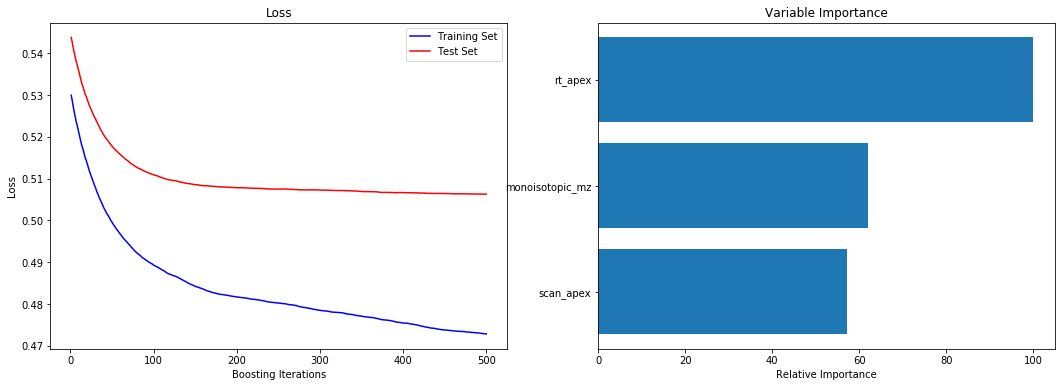

In [47]:
# Plot training loss

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.margins(0.06)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(params['n_estimators']) + 1, best_estimator.train_score_, 'b-', label='Training Set')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [48]:
# use the trained model to predict the intensity delta for the test set
y_test_predicted = best_estimator.predict(X_test)

#### train a model for each of the runs

In [49]:
mapping_df = pd.read_csv(MAPPING_FILE_NAME)
mapping_l = [tuple(r) for r in mapping_df.to_numpy()]

In [50]:
for mapping in mapping_l:
    file_idx_for_this_model = mapping[0]
    
    # filter out rows we don't want in the training set for this run-specific model
    training_set_for_run_df = training_set_df[(training_set_df.file_idx == file_idx_for_this_model)]
    print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

    # split the training set
    X = training_set_for_run_df[['monoisotopic_mz','rt_apex','scan_apex']].values
    y = training_set_for_run_df[['delta_intensity_mean']].values[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # train the model
    best_estimator.fit(X_train, y_train)
    train_score = best_estimator.score(X_train, y_train)
    test_score = best_estimator.score(X_test, y_test)
    print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

    # save the trained model
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx_for_this_model)
    with open(MODEL_FILE_NAME, 'wb') as file:
        pickle.dump(best_estimator, file)

there are 21219 sequences in the training set for file 0
R-squared for training set: 0.1, test set: 0.0
there are 21410 sequences in the training set for file 1
R-squared for training set: 0.1, test set: 0.1
there are 21115 sequences in the training set for file 2
R-squared for training set: 0.1, test set: 0.1
there are 21128 sequences in the training set for file 3
R-squared for training set: 0.1, test set: 0.0
there are 21167 sequences in the training set for file 4
R-squared for training set: 0.1, test set: 0.0
there are 21486 sequences in the training set for file 5
R-squared for training set: 0.1, test set: 0.1
there are 21874 sequences in the training set for file 6
R-squared for training set: 0.1, test set: 0.0
there are 21169 sequences in the training set for file 7
R-squared for training set: 0.1, test set: 0.0
there are 20821 sequences in the training set for file 8
R-squared for training set: 0.1, test set: 0.1
there are 21249 sequences in the training set for file 9
R-squar

#### use the run-specific models to estimate the intensity for all sequences in all runs

In [51]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified',
       'delta_intensity_median', 'delta_intensity_mean'],
      dtype='object')

In [52]:
sequences_l = []
for mapping in mapping_l:
    file_idx = mapping[0]
    
    # load the model for this run
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx)
    with open(MODEL_FILE_NAME, 'rb') as file:
        estimator = pickle.load(file)
    
    # get the sequences in this run
    df = sequences_df[sequences_df.file_idx == file_idx].copy()
    
    # build the list of sequences for inference
    X = df[['monoisotopic_mz','rt_apex','scan_apex']].values

    # predict the log2 delta intensity
    y = estimator.predict(X)
    
    df['estimated_delta_intensity'] = y
    df['normalised_intensity'] = df.log_intensity + y
    
    sequences_l.append(df)

sequences_df = pd.concat(sequences_l, axis=0, sort=False)

In [53]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified',
       'delta_intensity_median', 'delta_intensity_mean',
       'estimated_delta_intensity', 'normalised_intensity'],
      dtype='object')

In [54]:
sequences_with_species_df.to_pickle('/Users/darylwilding-mcbride/Downloads/sequences-df.pkl')
sequences_with_species_df.to_csv('/Users/darylwilding-mcbride/Downloads/sequences-df.csv', index=False)


In [55]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))
        
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [56]:
# subtract because we're in log2 space
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 - sequence_occurences_in_batch_df.intensity_1to1

In [57]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

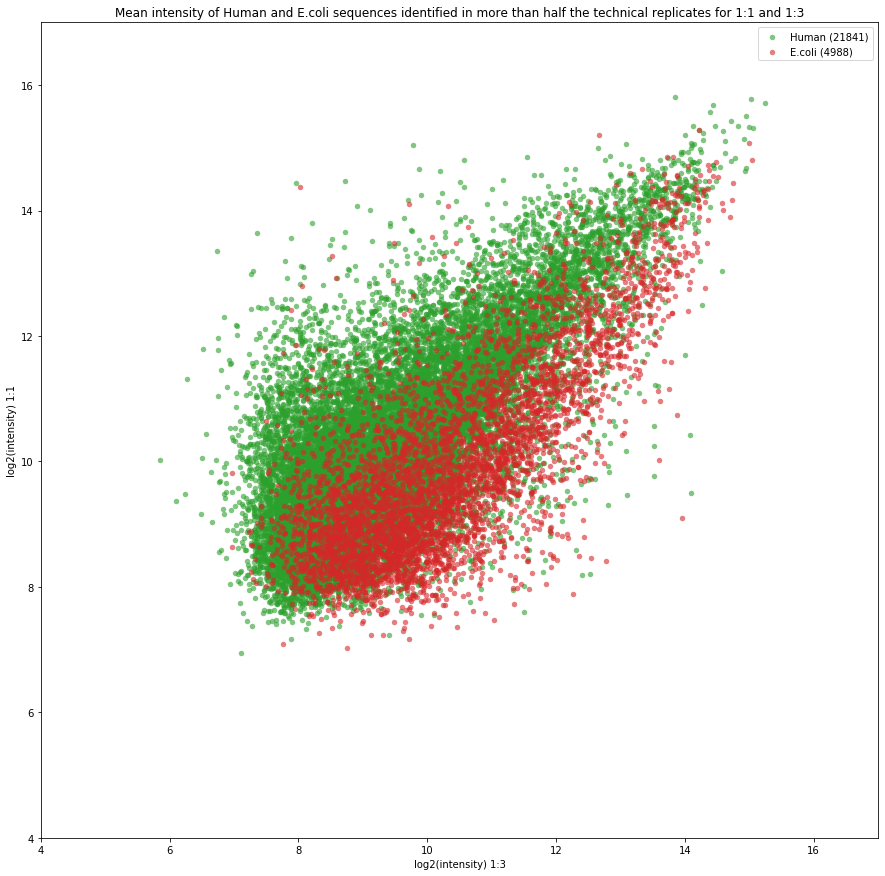

In [58]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(human_df.intensity_1to3, human_df.intensity_1to1, marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(ecoli_df.intensity_1to3, ecoli_df.intensity_1to1, marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

plt.xlim((4,17))
plt.ylim((4,17))

plt.show()

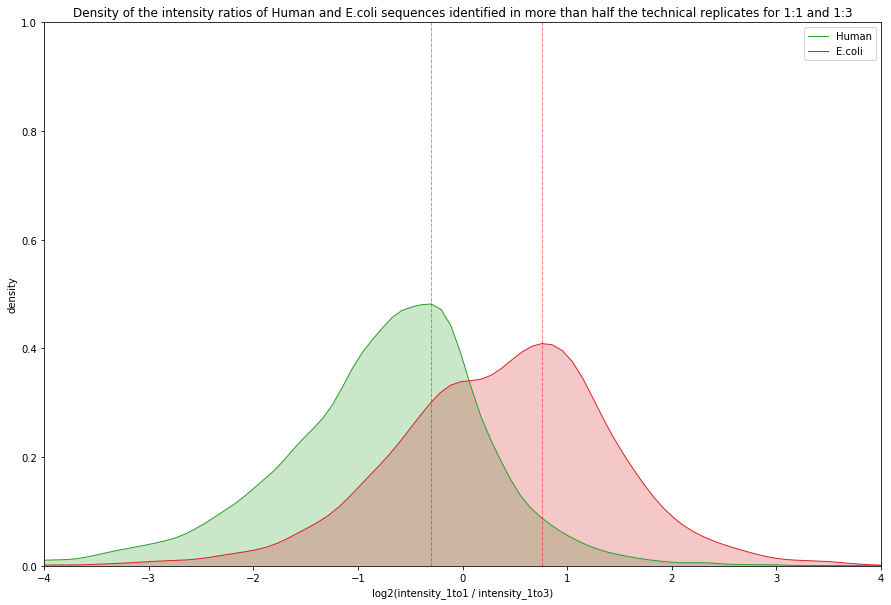

In [59]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

plt.xlim((-4,4))
plt.ylim((0,1))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

In [60]:
sequence_cv_by_batch_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','batch'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    batch = group_name[2]
    human = group_df.iloc[0].human
    df_temp = group_df.copy()
    df_temp['normalised_intensity_normal'] = np.power(2, df_temp.normalised_intensity) # convert to normal space to calculate CV
    normalised_intensity_cv = np.std(df_temp.normalised_intensity_normal) / np.mean(df_temp.normalised_intensity_normal)
    sequence_cv_by_batch_l.append((sequence, charge, batch, human, normalised_intensity_cv))
sequence_cv_by_batch_df = pd.DataFrame(sequence_cv_by_batch_l, columns=['sequence','charge','batch','human','normalised_intensity_cv'])

In [61]:
sequence_cv_by_batch_df.head()

,sequence,charge,batch,human,normalised_intensity_cv
0,AAAAAAAAAAAAAAAASAGGK,2,1to1,True,0.441340
1,AAAAAAAAAAAAAAAASAGGK,2,1to3,True,0.227265
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1to1,True,0.435361
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1to3,True,0.116004
4,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,1to1,True,0.254059


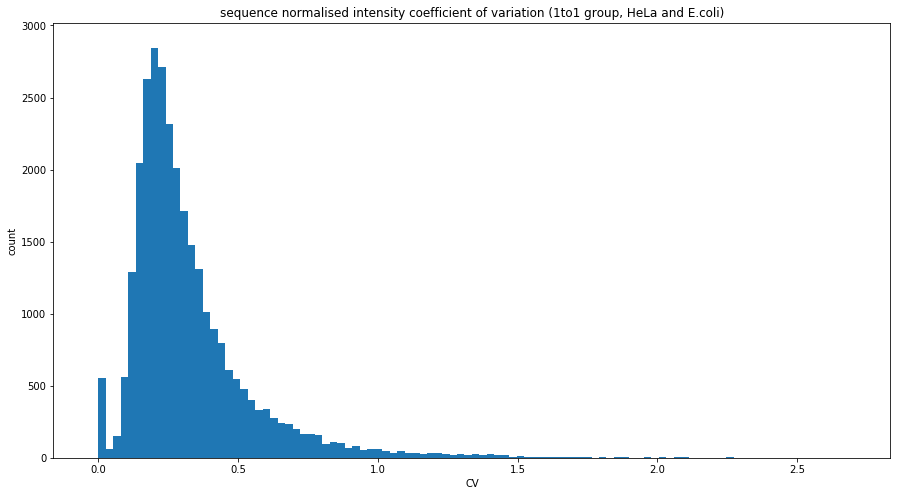

In [62]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence normalised intensity coefficient of variation (1to1 group, HeLa and E.coli)')

bins = 100
hist, bins, _ = plt.hist(sequence_cv_by_batch_df[sequence_cv_by_batch_df.batch == '1to1'].normalised_intensity_cv, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

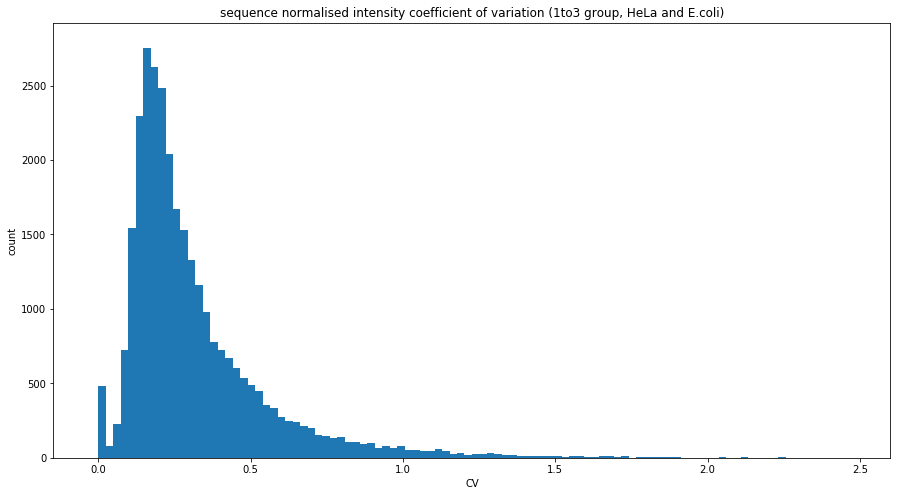

In [63]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence normalised intensity coefficient of variation (1to3 group, HeLa and E.coli)')

bins = 100
hist, bins, _ = plt.hist(sequence_cv_by_batch_df[sequence_cv_by_batch_df.batch == '1to3'].normalised_intensity_cv, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

#### calculate the experiment median and mean after normalisation

In [64]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified',
       'delta_intensity_median', 'delta_intensity_mean',
       'estimated_delta_intensity', 'normalised_intensity'],
      dtype='object')

In [65]:
# find the experiment-wide intensity median
experiment_intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    median_normalised_intensity = group_df.normalised_intensity.median()
    mean_normalised_intensity = group_df.normalised_intensity.mean()
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,median_normalised_intensity,mean_normalised_intensity))

experiment_intensities_post_normalisation_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','median_normalised_intensity','mean_normalised_intensity'])

In [66]:
sequences_df = pd.merge(sequences_df, experiment_intensities_post_normalisation_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [67]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified',
       'delta_intensity_median', 'delta_intensity_mean',
       'estimated_delta_intensity', 'normalised_intensity',
       'median_normalised_intensity', 'mean_normalised_intensity'],
      dtype='object')

In [68]:
sequences_df['normalised_delta'] = sequences_df.normalised_intensity - sequences_df.mean_normalised_intensity

In [69]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_top_3', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'intensity', 'classed_as', 'run_name', 'batch', 'human',
       'log_intensity', 'median_intensity_in_experiment',
       'mean_intensity_in_experiment', 'number_of_runs_identified',
       'delta_intensity_median', 'delta_intensity_mean',
       'estimated_delta_intensity', 'normalised_intensity',
       'median_normalised_intensity', 'mean_normalised_intensity',
       'normalised_delta'],
      dtype='object')

#### plot the variation of delta intensity with RT

In [70]:
df = sequences_df.copy()
df = df[df.file_idx == 2]

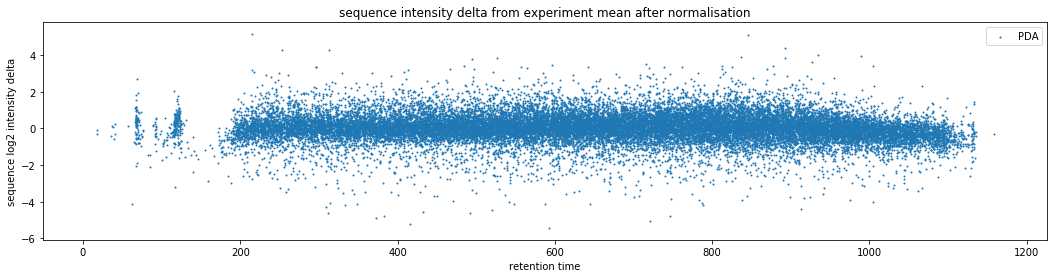

In [71]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean after normalisation')

ax.scatter(df.rt_apex, df.delta_intensity_mean, marker='o', lw=0, s=4, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))

plt.show()

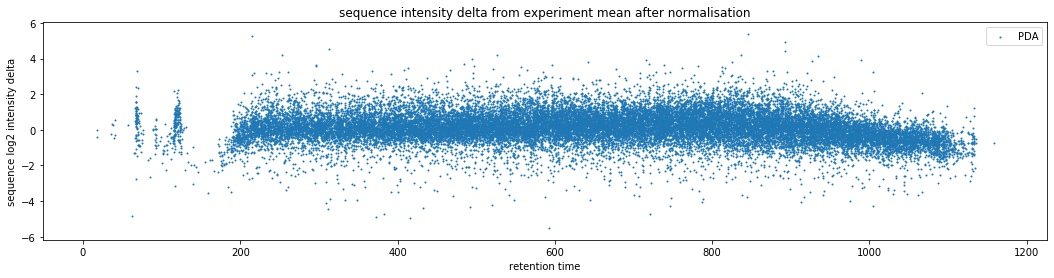

In [72]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean after normalisation')

ax.scatter(df.rt_apex, df.normalised_delta, marker='o', lw=0, s=4, alpha=1.0, label="PDA")

plt.legend(loc='best')
plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))

plt.show()